# Linear Regression Models



# PART 1: Linear Regression for Crash Data
We will use the same approach as the violation data, looking only at outside influences and see if we can model the number of daily intersection crashes in Chicago

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [73]:
def cross_val(model, X, y):
    # return a cross val score for my models
    pred = cross_val_score(model, X, y, cv=5)
    return pred.mean()

def print_evaluate(true, predicted):  
    # print out all of my stats for the model
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    # get multiple stats on my model predictions
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [74]:
conn = create_connection('database/rlc.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc.db


In [75]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t-' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('all_hours',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('rlc_all_hours',), ('daily_covid',), ('holidays',)]
cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_o

In [249]:
# Try to add in rlc_state to a very big already query
crash_df = pd.read_sql_query('''
WITH 
ah AS (SELECT MAX(rlc_state) as rlc_state,
            year,
            month,
            day,
            intersection
    FROM rlc_all_hours 
    GROUP BY year, month, day, intersection),

v AS (SELECT intersection,
            SUM(violations) AS violations,
            month,
            day,
            year,
            violation_date
    FROM daily_violations
    GROUP BY year, month, day, intersection
    ),

cr AS(SELECT year,
             month,
             day,
             COUNT(crash_record_id) AS n_crash,
             SUM(injuries_total) as injuries_total,
             SUM(injuries_fatal) as injuries_fatal

     FROM signal_crashes
     GROUP BY year, month, day
    ),

ic AS
    (SELECT region_id,
            intersection
     FROM intersection_cams
    ),



c AS
    (
        WITH allcg as 
             (SELECT AVG(speed) as speed,
                     AVG(quantile_speed) as quantile_speed,
                     100-AVG(quantile_speed) as avg_congestion,
                     MIN(speed) as min_speed,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             GROUP BY year, month, day, region_id
            ),

            rh1 as 
             (SELECT 
                    AVG(speed) as morning_rush_speed,
                    MIN(quantile_speed) as morning_rush_quant,
                    100 - MIN(quantile_speed) as morning_rush_congestion,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             WHERE hour > 5 AND hour < 10
             GROUP BY year, month, day, region_id
            ),

            rh2 as 
             (SELECT MIN(speed) as afternoon_rush_speed,
                    MIN(quantile_speed) as afternoon_rush_quant,
                    100 - MIN(quantile_speed) as afternoon_rush_congestion,
                    region_id,
                    month,
                    day,
                    year
             FROM hourly_congestion
             WHERE hour > 16 AND hour < 20
             GROUP BY year, month, day, region_id
            )

    SELECT allcg.speed,
           allcg.min_speed,
           allcg.region_id,
            allcg.month,
            allcg.day,
            allcg.weekday,
            allcg.year,
            allcg.quantile_speed,
            allcg.avg_congestion,

            rh1.morning_rush_speed,
            rh1.morning_rush_quant,
            rh1.morning_rush_congestion,

            rh2.afternoon_rush_speed,
            rh2.afternoon_rush_quant,
            rh2.afternoon_rush_congestion

     FROM allcg
     LEFT JOIN rh1
         ON rh1.year = allcg.year
         AND rh1.month = allcg.month
         AND rh1.day = allcg.day
         AND rh1.region_id = allcg.region_id
     LEFT JOIN rh2
         ON rh2.year = allcg.year
         AND rh2.month = allcg.month
         AND rh2.day = allcg.day
         AND rh2.region_id = allcg.region_id

     ORDER BY allcg.year, allcg.month, allcg.day, allcg.region_id
),


 wx as
    (SELECT MAX(temp) as temp,
            SUM(snow_1h)+SUM(rain_1h) as precip,
            month,
            day,
            weekday,
            year,
            SUM(snow_1h) as snow,
            SUM(rain_1h) as rain
     FROM hourly_weather
     GROUP BY year, month, day
    )

SELECT  SUM(v.violations) as violations,
        v.year,
        v.month,
        v.day,

        cr.injuries_total,
        cr.injuries_fatal,
        cr.n_crash,

        AVG(c.speed) as speed, 
        (100 - AVG(CAST(c.quantile_speed as REAL)))/100 as avg_congestion,
        CAST(c.min_speed as REAL) as min_speed,
        AVG(c.morning_rush_speed) as morning_rush_speed,
        AVG(c.morning_rush_quant) as morning_rush_quant,
        (AVG(c.morning_rush_congestion))/100 as morning_rush_congestion,

        AVG(c.afternoon_rush_speed) as afternoon_rush_speed,
        AVG(c.afternoon_rush_quant) as afternoon_rush_quant,
        (AVG(c.afternoon_rush_congestion))/100 as afternoon_rush_congestion,

        wx.weekday,
        wx.precip,
        wx.temp,
        wx.snow,
        wx.rain,
        
        COUNT(ah.rlc_state) as n_cams,
        COUNT(ah.rlc_state==0) as cams_off

        

FROM v
LEFT JOIN ic
      ON v.intersection = ic.intersection
LEFT JOIN ah
    ON ah.year = v.year
    AND ah.month = v.month
    AND ah.day = v.day
    AND ah.intersection = v.intersection
LEFT JOIN c
      ON c.year = v.year
      AND c.month = v.month
      AND c.day = v.day
      AND c.region_id = ic.region_id
LEFT JOIN wx
      ON wx.year = v.year
      AND wx.month = v.month
      AND wx.day = v.day
LEFT JOIN cr
      ON cr.year = v.year
      AND cr.month = v.month
      AND cr.day = v.day
WHERE v.violation_date >= \'2017-09-01\' AND v.violation_date <= \'2020-12-31\' 

GROUP BY v.year, v.month, v.day

ORDER BY v.year, v.month, v.day

''', conn)

# LOOKS GOOD!!
print(crash_df.info())
crash_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 23 columns):
violations                   1217 non-null int64
year                         1217 non-null int64
month                        1217 non-null int64
day                          1217 non-null int64
injuries_total               1217 non-null int64
injuries_fatal               1217 non-null int64
n_crash                      1217 non-null int64
speed                        1202 non-null float64
avg_congestion               1202 non-null float64
min_speed                    1202 non-null float64
morning_rush_speed           1187 non-null float64
morning_rush_quant           1187 non-null float64
morning_rush_congestion      1187 non-null float64
afternoon_rush_speed         1192 non-null float64
afternoon_rush_quant         1192 non-null float64
afternoon_rush_congestion    1192 non-null float64
weekday                      1217 non-null int64
precip                       1217 non-null

,violations,year,month,day,injuries_total,injuries_fatal,n_crash,speed,avg_congestion,min_speed,morning_rush_speed,morning_rush_quant,morning_rush_congestion,afternoon_rush_speed,afternoon_rush_quant,afternoon_rush_congestion,weekday,precip,temp,snow,rain,n_cams,cams_off
0,1704,2017,9,1,22,0,39,22.693942,0.626901,23.748333,21.440603,12.106900,0.878931,18.826903,5.208570,0.947914,4,0.00,294.15,0.0,0.00,144,144
1,1623,2017,9,2,16,0,30,23.965360,0.503577,26.930000,25.253151,49.488127,0.505119,21.525069,22.243180,0.777568,5,0.00,297.15,0.0,0.00,143,143
2,1494,2017,9,3,5,0,29,24.892638,0.389212,27.898333,26.114819,62.351127,0.376489,23.260429,42.655756,0.573442,6,6.60,302.15,0.0,6.60,139,139
3,1258,2017,9,4,9,0,19,24.509224,0.441270,28.285000,25.901678,64.182735,0.358173,23.335408,42.007748,0.579923,0,1.12,303.15,0.0,1.12,142,142
4,1366,2017,9,5,10,0,39,22.674090,0.622437,22.885000,20.890598,6.379359,0.936206,18.663253,3.675793,0.963242,1,0.00,297.15,0.0,0.00,144,144


In [250]:
# rough number of expected output.  We are very close. Could be more or fewer intersections for parts
365*3.25

1186.25

In [251]:
# Change weekday to string
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crash_df['weekday'] = crash_df['weekday'].apply(lambda x: days_of_week[x])

In [252]:
crash_df.morning_rush_congestion.head()

0    0.878931
1    0.505119
2    0.376489
3    0.358173
4    0.936206
Name: morning_rush_congestion, dtype: float64




****************************************************************************************************
*                                            VIOLATIONS                                            *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     36.71
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           1.83e-09
Time:                        10:25:08   Log-Likelihood:                -4586.7
No. Observations:                1217   AIC:                             9177.
Df Residuals:                    1215   BIC:                             91

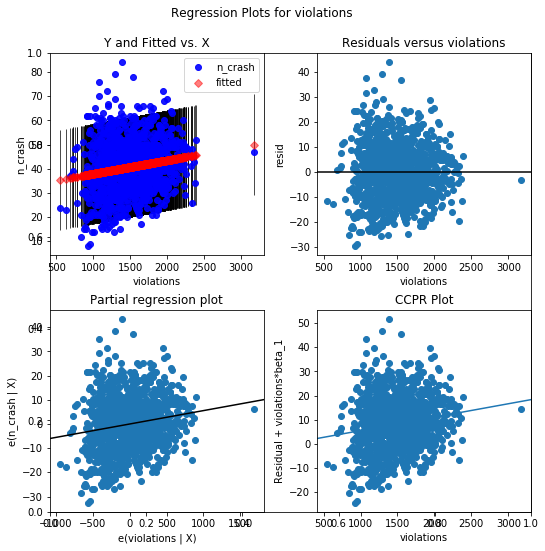

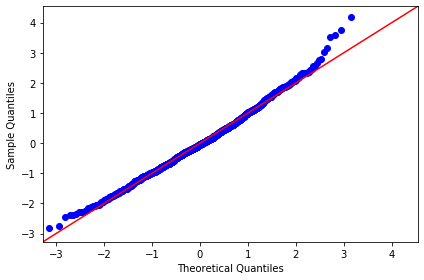




****************************************************************************************************
*                                     AFTERNOON_RUSH_CONGESTION                                    *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     94.81
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           1.31e-21
Time:                        10:25:10   Log-Likelihood:                -4463.8
No. Observations:                1192   AIC:                             8932.
Df Residuals:                    1190   BIC:                             89

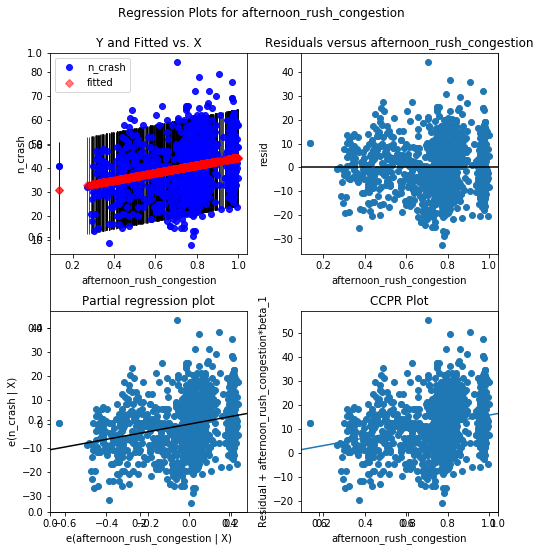

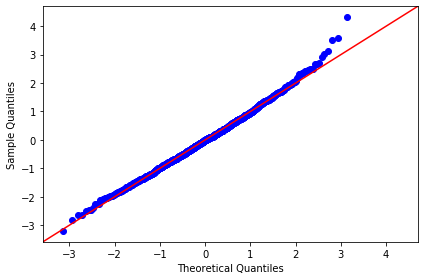




****************************************************************************************************
*                                               TEMP                                               *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.785
Date:                Tue, 02 Mar 2021   Prob (F-statistic):            0.00931
Time:                        10:25:11   Log-Likelihood:                -4601.4
No. Observations:                1217   AIC:                             9207.
Df Residuals:                    1215   BIC:                             92

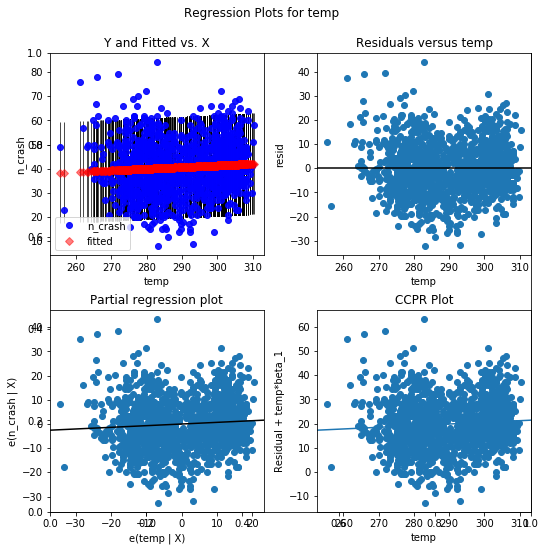

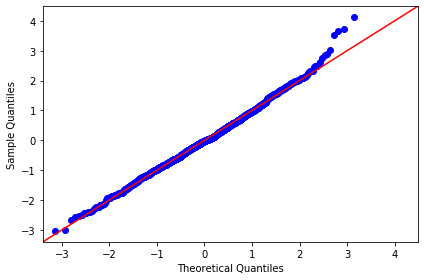




****************************************************************************************************
*                                               SNOW                                               *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4980
Date:                Tue, 02 Mar 2021   Prob (F-statistic):              0.481
Time:                        10:25:12   Log-Likelihood:                -4604.5
No. Observations:                1217   AIC:                             9213.
Df Residuals:                    1215   BIC:                             92

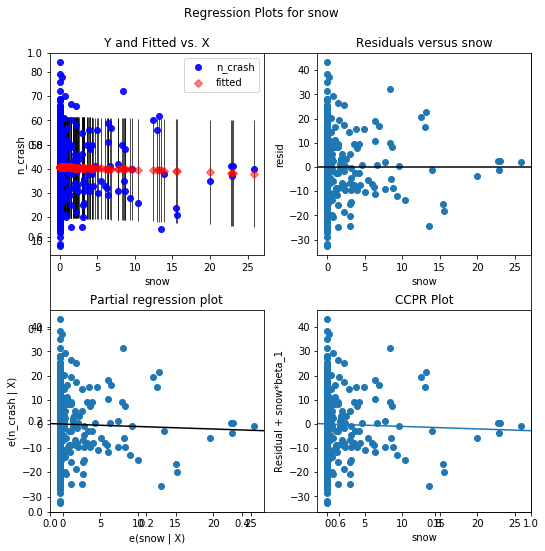

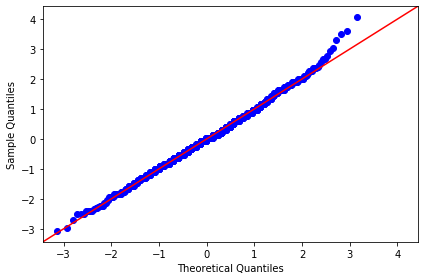




****************************************************************************************************
*                                               RAIN                                               *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     9.826
Date:                Tue, 02 Mar 2021   Prob (F-statistic):            0.00176
Time:                        10:25:14   Log-Likelihood:                -4599.9
No. Observations:                1217   AIC:                             9204.
Df Residuals:                    1215   BIC:                             92

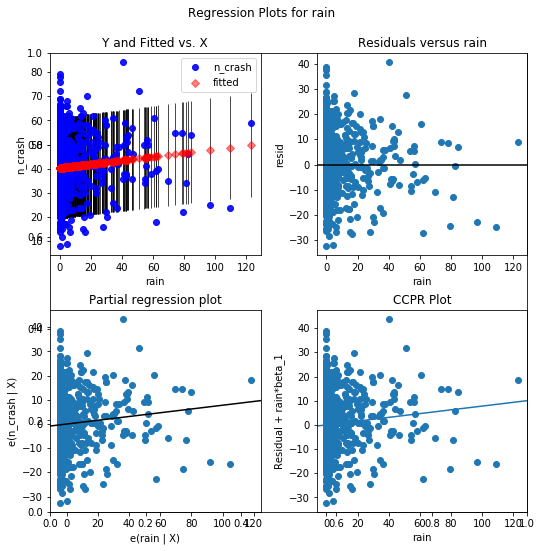

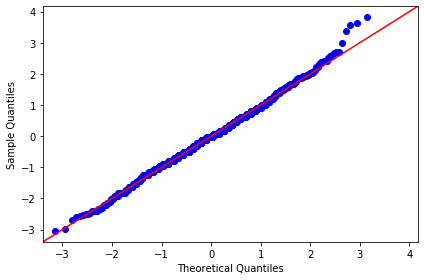




****************************************************************************************************
*                                              N_CAMS                                              *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     21.10
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           4.82e-06
Time:                        10:25:15   Log-Likelihood:                -4594.3
No. Observations:                1217   AIC:                             9193.
Df Residuals:                    1215   BIC:                             92

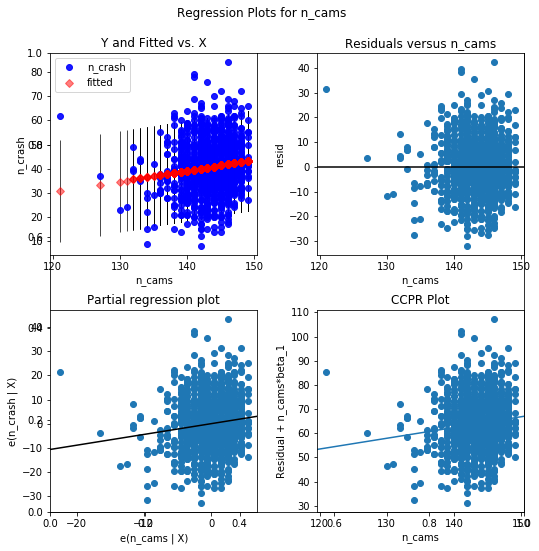

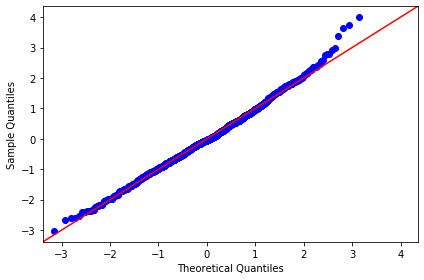




****************************************************************************************************
*                                              N_CRASH                                             *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.597e+32
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:25:17   Log-Likelihood:                 36837.
No. Observations:                1217   AIC:                        -7.367e+04
Df Residuals:                    1215   BIC:                        -7.366e

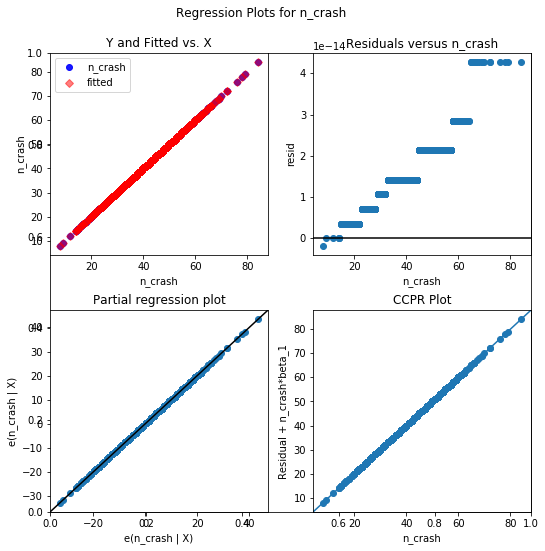

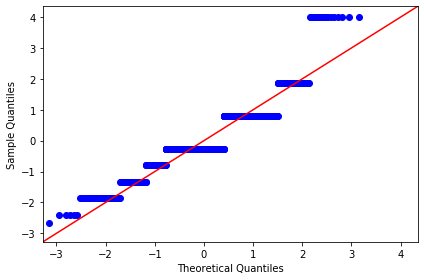

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
3,snow,0.000410,4.073676e+01,-0.103161,4.805031e-01,11.526644
2,temp,0.005553,2.085901e+01,0.068422,9.307105e-03,16.812192
4,rain,0.008022,4.033371e+01,0.077656,1.761987e-03,9.452378
5,n_cams,0.017067,-2.325657e+01,0.445547,4.822002e-06,16.419391
0,violations,0.029327,3.242218e+01,0.005549,1.827018e-09,25.856675
1,afternoon_rush_congestion,0.073792,2.859021e+01,15.842694,1.309843e-21,15.848276
6,n_crash,1.000000,6.217249e-15,1.000000,0.000000e+00,545.354909


In [253]:
# Lets look at some regressions for all of my chosen columns
# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# Eliminated and useful features
target = 'n_crash'
keepers = ['violations', 'afternoon_rush_congestion', 
           'weekday', 'temp', 'snow', 'precip', 'n_cams', 'n_crash']

#drop_me.remove(target)
categoricals = ['weekday']

df_cont = crash_df.copy()[keepers]
df_cont.drop(columns=categoricals, inplace=True)



results = []

for idx, column in enumerate(df_cont.columns):
    
    print('\n'*2)
    print('*'*100)
    print('*' + (49-len(column)//2)*' ' + column.upper() + (49-len(column)//2 - len(column)%2)*' ' + '*')
    print('*'*100)

    print ("Red Light Camera - Regression Analysis and Diagnostics Violations")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
    fig, axes = plt.subplots(figsize=(8,8))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')

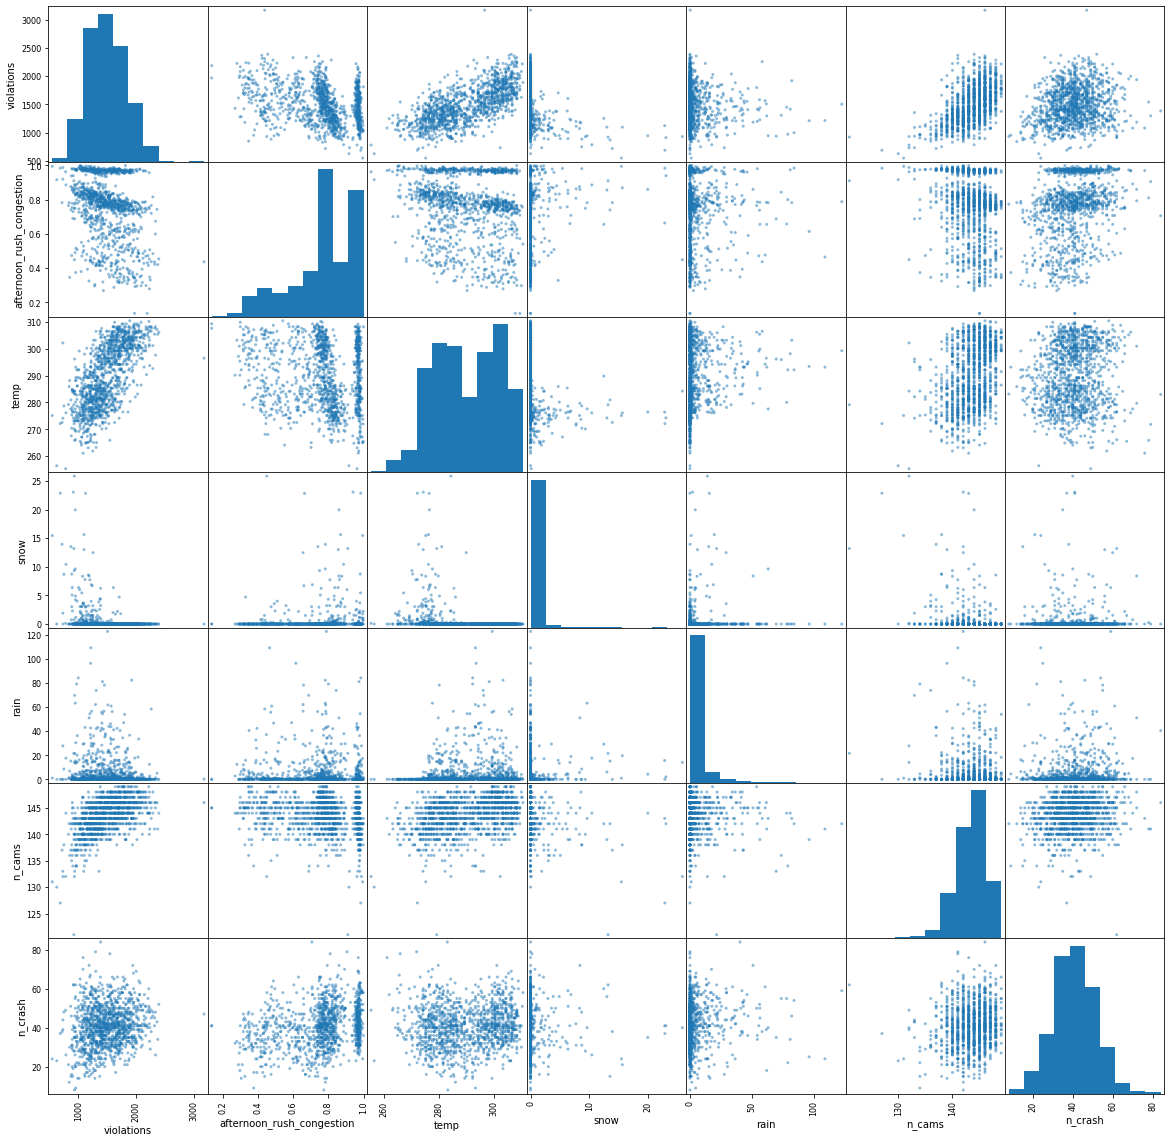

In [254]:
# scatter plot takes a few min

pd.plotting.scatter_matrix(df_cont,figsize  = [20, 20]);
plt.show()

In [255]:
df_cont.corr()  # create a correlation matrix

,violations,afternoon_rush_congestion,temp,snow,rain,n_cams,n_crash
violations,1.000000,-0.318495,0.681941,-0.275591,-0.083812,0.543651,0.171250
afternoon_rush_congestion,-0.318495,1.000000,-0.140838,0.040417,-0.043925,-0.163856,0.271647
temp,0.681941,-0.140838,1.000000,-0.235550,0.092341,0.367890,0.074519
snow,-0.275591,0.040417,-0.235550,1.000000,0.059612,-0.248076,-0.020242
rain,-0.083812,-0.043925,0.092341,0.059612,1.000000,-0.065346,0.089567
n_cams,0.543651,-0.163856,0.367890,-0.248076,-0.065346,1.000000,0.130640
n_crash,0.171250,0.271647,0.074519,-0.020242,0.089567,0.130640,1.000000


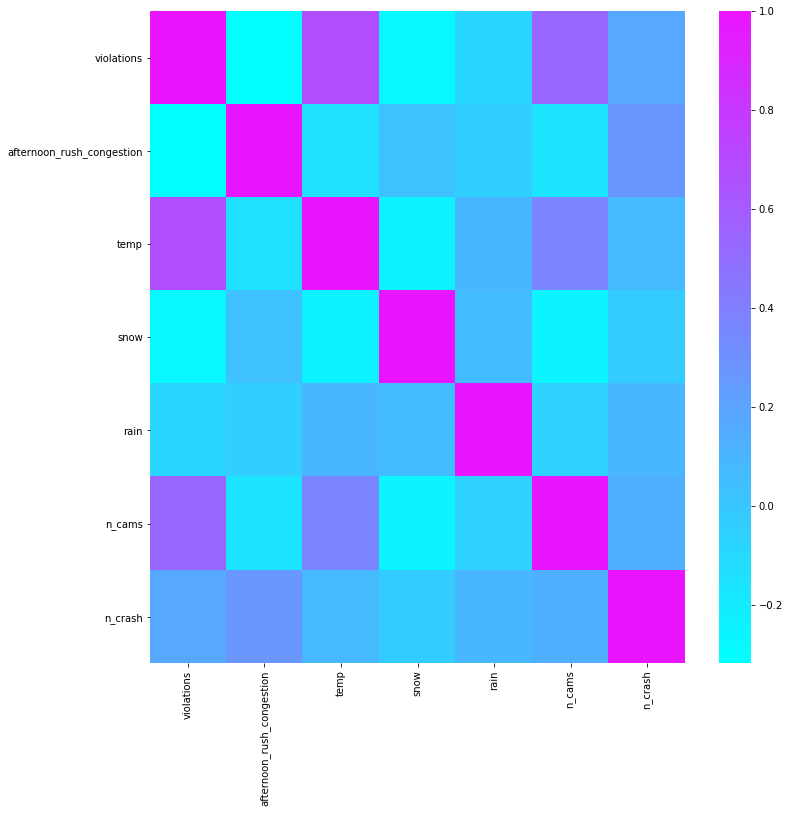

In [256]:
import seaborn as sns

plt.figure(figsize = (12,12))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [257]:
df_continuous.columns

Index(['violations', 'avg_congestion', 'morning_rush_congestion',
       'afternoon_rush_congestion', 'temp', 'snow', 'rain', 'n_cams',
       'n_crash'],
      dtype='object')

In [258]:
# get rid of categories that have high correlation and others.
df_continuous = df_cont.copy()
df_ohe = crash_df.copy()[categoricals]

#string_me = ['month', 'year']
#df_ohe[string_me] = df_ohe[string_me].astype(str)

# One hot encoding   
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [259]:
pd.options.display.max_columns = 100
df_final.head()

,violations,afternoon_rush_congestion,temp,snow,rain,n_cams,n_crash,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,1704,0.947914,294.15,0.0,0.00,144,39,0,0,0,0,0,0
1,1623,0.777568,297.15,0.0,0.00,143,30,0,1,0,0,0,0
2,1494,0.573442,302.15,0.0,6.60,139,29,0,0,1,0,0,0
3,1258,0.579923,303.15,0.0,1.12,142,19,1,0,0,0,0,0
4,1366,0.963242,297.15,0.0,0.00,144,39,0,0,0,0,1,0


In [260]:
df_final.dropna(inplace=True)

### Test train split

In [261]:
X = df_final.drop(['n_crash'], axis=1)
y = df_final['n_crash']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [262]:
reg = LinearRegression()
reg.fit(X, y)  # my regression object

pred = reg.predict(X_test)

(0, 60)

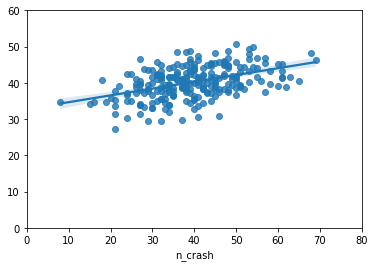

In [263]:
sns.regplot(y_test, pred)
plt.xlim(0,80)
plt.ylim(0,60)

### Plot residuals

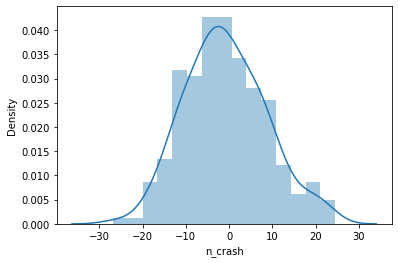

In [264]:
sns.distplot((y_test - pred), bins=15);

In [265]:
test_pred = reg.predict(X_test)
train_pred = reg.predict(X_train)

print("Linear Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Linear Regression Results:
Test set:
MAE: 7.597165066481954
MSE: 89.55579265086514
RMSE: 9.463392238033101
R2 Square 0.19498469728184586

Train set:
MAE: 7.434987699101361
MSE: 89.50582120974843
RMSE: 9.460751619704876
R2 Square 0.2081456023400512


In [266]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(reg, X_train, y_train)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,7.597165,89.555793,9.463392,0.194985,0.187173


In [267]:
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:28}{}'.format(var, coefficients[var]))



violations                  0.009430913009397364
afternoon_rush_congestion   22.32140632423426
temp                        -0.08393550006148229
snow                        0.1390765207313165
rain                        0.1252035026576259
n_cams                      0.23189347381797062
weekday_Monday              -4.709006126166959
weekday_Saturday            -0.06913672577590341
weekday_Sunday              -4.017682927766995
weekday_Thursday            -3.6932528219070737
weekday_Tuesday             -3.2131784055397876
weekday_Wednesday           -4.2639497166502025


## Try Ridge Regression
Would like to try this since we likely have collinearity in our dataset.

In [94]:
from sklearn.linear_model import Ridge, RidgeCV

model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100])
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print("Ridge Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Ridge Regression Results:
Test set:
MAE: 7.7227451087063805
MSE: 95.55992509871706
RMSE: 9.775475696799468
R2 Square 0.22079023434920997

Train set:
MAE: 7.413852414631819
MSE: 88.18276379003166
RMSE: 9.39056780977762
R2 Square 0.20083713686689064


Ridge regression showed no improvement on original model.

In [95]:
ridge = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(RidgeCV(), X_train, y_train)]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(ridge, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,7.606335,92.597762,9.622773,0.244944,0.164110
1,Ridge Regression,7.722745,95.559925,9.775476,0.220790,0.162849


In [96]:
#from sklearn.cross_validation import KFold



# Good time to do a baseline r_squared calculation
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(reg, X, y, scoring='r2', cv=crossvalidation))

# Do the actual regression
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

print('Baseline r_squared val:', baseline)

  violations: 0.009225175204683408
morning_rush_congestion: 1.5145847779770811
afternoon_rush_congestion: 20.808772717110447
      precip: 0.12549224739629009
        temp: -0.08692660902119458
      n_cams: 0.12720190613566168
    cams_off: 0.12720190613566112
weekday_Monday: -4.660050174247228
weekday_Saturday: 0.18707981818968825
weekday_Sunday: -3.8430025686214653
weekday_Thursday: -3.701477927545373
weekday_Tuesday: -3.297740104231207
weekday_Wednesday: -4.261893571270478
Baseline r_squared val: 0.18364626617762683


# PART 2: Linear regression for red light violations

## Query our data
We will start by making a model to measure changing outside effects on our crashes.  These are weather, traffic, and temporal.  I will do d separate and simpler study of intersection characteristics and how they affect crashes.


I would like to get daily red light camera intersection data with the following columns:
- violations
- weekday
- month
- year
- region   (can add this post query with lambda function from intersection_cams and region_data tables, ugh!)
- congestion (try peak, rush hour, average, etc)
- precipitation
- max_temp

Each intersection should have one entry per day.  Weather will use aggregate daily values.
Congestion will use aggragate also, although I am look for congestion at rush hour as a factor.


In [142]:
# get a df with all relevant data.

int_df = pd.read_sql_query('''
WITH 
    ah AS(
        SELECT *
        FROM rlc_all_hours
        GROUP by year, month, day
        ),

    v as
    (SELECT intersection,
            SUM(violations) AS violations,
            month,
            day,
            year,
            violation_date
    FROM daily_violations
    GROUP BY year, month, day, intersection
    ),

ic as
    (SELECT region_id,
            intersection
     FROM intersection_cams
    ),



c as
    (
        WITH allcg as 
             (SELECT AVG(speed) as speed,
                     AVG(quantile_speed) as quantile_speed,
                     100-AVG(quantile_speed) as avg_congestion,
                     MIN(speed) as min_speed,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             GROUP BY year, month, day, region_id
            ),

            rh1 as 
             (SELECT 
                    AVG(speed) as morning_rush_speed,
                    MIN(quantile_speed) as morning_rush_quant,
                    100 - MIN(quantile_speed) as morning_rush_congestion,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             WHERE hour > 5 AND hour < 10
             GROUP BY year, month, day, region_id
            ),

            rh2 as 
             (SELECT MIN(speed) as afternoon_rush_speed,
                    MIN(quantile_speed) as afternoon_rush_quant,
                    100 - MIN(quantile_speed) as afternoon_rush_congestion,
                    region_id,
                    month,
                    day,
                    year
             FROM hourly_congestion
             WHERE hour > 16 AND hour < 20
             GROUP BY year, month, day, region_id
            )

    SELECT AVG(allcg.min_speed) as min_speed,
            AVG(allcg.speed) as speed,
            allcg.month,
            allcg.day,
            allcg.weekday,
            allcg.year,
            AVG(allcg.quantile_speed) as quantile_speed,
            AVG(allcg.avg_congestion) as avg_congestion,

            AVG(rh1.morning_rush_speed) as morning_rush_hour,
            AVG(rh1.morning_rush_quant) as morning_rush_quant ,
            AVG(rh1.morning_rush_congestion) as morning_rush_congestion,
            AVG(rh1.morning_rush_speed) as morning_rush_speed,

            AVG(rh2.afternoon_rush_speed) as afternoon_rush_speed,
            AVG(rh2.afternoon_rush_quant) as afternoon_rush_quant,
            AVG(rh2.afternoon_rush_congestion) as afternoon_rush_congestion

     FROM allcg
     LEFT JOIN rh1
         ON rh1.year = allcg.year
         AND rh1.month = allcg.month
         AND rh1.day = allcg.day
         AND rh1.region_id = allcg.region_id
     LEFT JOIN rh2
         ON rh2.year = allcg.year
         AND rh2.month = allcg.month
         AND rh2.day = allcg.day
         AND rh2.region_id = allcg.region_id
     
     GROUP BY allcg.year, allcg.month, allcg.day
     ORDER BY allcg.year, allcg.month, allcg.day
),


 wx as
    (SELECT temp,
            SUM(snow_1h)+SUM(rain_1h) as precip,
            month,
            day,
            weekday,
            year    
     FROM hourly_weather
     GROUP BY year, month, day
    ),
cov as
    (SELECT CAST(cases_total as INT) as cases_total,
            lab_report_date
    FROM daily_covid
            
    )

SELECT  SUM(v.violations) as violations,
        v.year,
        CAST(v.month as INT) as month,
        v.day,

        AVG(c.speed) as speed, 
        CAST(c.quantile_speed as REAL) as quantile_speed,
        CAST(c.min_speed as REAL) as min_speed,
        AVG(c.avg_congestion) as avg_congestion,
        AVG(c.morning_rush_quant) as morning_rush_quant,
        (AVG(c.morning_rush_congestion))/100 as morning_rush_congestion,

        AVG(c.afternoon_rush_speed) as afternoon_rush_speed,
        AVG(c.afternoon_rush_quant) as afternoon_rush_quant,
        (AVG(c.afternoon_rush_congestion))/100 as afternoon_rush_congestion,

        wx.weekday,
        wx.precip,
        wx.temp,
        cov.cases_total,
        AVG(c.morning_rush_speed) as morning_rush_speed

        

FROM v
LEFT JOIN ah
    ON v.year = ah.year
    AND v.month = ah.month
    AND v.day = ah.day
LEFT JOIN ic
  ON v.intersection = ic.intersection
LEFT JOIN c
  ON c.year = v.year
      AND c.month = v.month
      AND c.day = v.day
LEFT JOIN wx
  ON wx.year = v.year
      AND wx.month = v.month
      AND wx.day = v.day
LEFT JOIN cov
    ON DATE(cov.lab_report_date) = DATE(v.violation_date)

    
WHERE v.violation_date >= \'2017-09-01\' AND v.violation_date <= \'2020-12-31\' 

GROUP BY v.year, v.month, v.day

ORDER BY v.year, v.month, v.day

                                    ''', conn)

# LOOKS GOOD!!
print(int_df.info())
int_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 18 columns):
violations                   1217 non-null int64
year                         1217 non-null int64
month                        1217 non-null int64
day                          1217 non-null int64
speed                        1202 non-null float64
quantile_speed               1202 non-null float64
min_speed                    1202 non-null float64
avg_congestion               1202 non-null float64
morning_rush_quant           1187 non-null float64
morning_rush_congestion      1187 non-null float64
afternoon_rush_speed         1192 non-null float64
afternoon_rush_quant         1192 non-null float64
afternoon_rush_congestion    1192 non-null float64
weekday                      1217 non-null int64
precip                       1217 non-null float64
temp                         1217 non-null float64
cases_total                  305 non-null float64
morning_rush_speed           1187 non

,violations,year,month,day,speed,quantile_speed,min_speed,avg_congestion,morning_rush_quant,morning_rush_congestion,afternoon_rush_speed,afternoon_rush_quant,afternoon_rush_congestion,weekday,precip,temp,cases_total,morning_rush_speed
0,1704,2017,9,1,24.150353,39.575660,19.306782,60.424340,12.820329,0.871797,20.869598,10.065892,0.899341,4,0.00,294.15,NaN,23.075891
1,1623,2017,9,2,25.115606,49.437830,21.337644,50.562170,46.627070,0.533729,22.993506,23.600817,0.763992,5,0.00,292.15,NaN,26.325906
2,1494,2017,9,3,26.002740,60.754535,22.096494,39.245465,58.017443,0.419826,24.317931,41.146516,0.588535,6,6.60,295.15,NaN,27.089282
3,1258,2017,9,4,25.515766,54.635059,23.222586,45.364941,58.417261,0.415827,24.023103,36.393470,0.636065,0,1.12,300.15,NaN,26.765173
4,1366,2017,9,5,24.122026,39.798663,19.216897,60.201337,11.788381,0.882116,20.264483,5.074259,0.949257,1,0.00,297.15,NaN,22.672759


Now we have a pretty solid dataframe to do analysis on the red light intersections.

We would like to know what factors affect the target (violations)

In [143]:
int_df.cases_total.fillna(0, inplace=True)
int_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 18 columns):
violations                   1217 non-null int64
year                         1217 non-null int64
month                        1217 non-null int64
day                          1217 non-null int64
speed                        1202 non-null float64
quantile_speed               1202 non-null float64
min_speed                    1202 non-null float64
avg_congestion               1202 non-null float64
morning_rush_quant           1187 non-null float64
morning_rush_congestion      1187 non-null float64
afternoon_rush_speed         1192 non-null float64
afternoon_rush_quant         1192 non-null float64
afternoon_rush_congestion    1192 non-null float64
weekday                      1217 non-null int64
precip                       1217 non-null float64
temp                         1217 non-null float64
cases_total                  1217 non-null float64
morning_rush_speed           1187 no

In [144]:
# rough number of expected output.  We are very close. Could be more or fewer intersections for parts
365*3.25

1186.25

In [145]:
int_df.dropna(inplace=True)

In [146]:
# Change weekday to string
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
int_df['weekday'] = int_df['weekday'].apply(lambda x: days_of_week[x])

months = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']

int_df['month'] = int_df['month'].apply(lambda x: months[x-1])


In [147]:
int_df.columns

Index(['violations', 'year', 'month', 'day', 'speed', 'quantile_speed',
       'min_speed', 'avg_congestion', 'morning_rush_quant',
       'morning_rush_congestion', 'afternoon_rush_speed',
       'afternoon_rush_quant', 'afternoon_rush_congestion', 'weekday',
       'precip', 'temp', 'cases_total', 'morning_rush_speed'],
      dtype='object')

In [149]:
# Lets look at some regressions for all of my chosen columns



# Eliminated and useful features
target = 'violations'
drop_me = ['day', 'min_speed', 'speed', 'quantile_speed', 'avg_congestion', 'month',
          'afternoon_rush_speed', 'morning_rush_speed', 'year', 'afternoon_rush_congestion',
          'morning_rush_congestion']
categoricals = ['weekday', 'month']

df_cont = int_df.copy()
df_cont.drop(columns=drop_me+categoricals, inplace=True)



results = []

for idx, column in enumerate(df_cont.columns):
    
    print('\n'*2)
    print('*'*100)
    print('*' + (49-len(column)//2)*' ' + column.upper() + (49-len(column)//2 - len(column)%2)*' ' + '*')
    print('*'*100)

    print ("Red Light Camera - Regression Analysis and Diagnostics Violations")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
    #fig, axes = plt.subplots(figsize=(15,12))
    #fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    #fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    #fig.tight_layout()
    #plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')




****************************************************************************************************
*                                            VIOLATIONS                                            *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:             violations   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.014e+32
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:32:44   Log-Likelihood:                 30846.
No. Observations:                1182   AIC:                        -6.169e+04
Df Residuals:                    1180   BIC:                        -6.168e


****************************************************************************************************
*                                            CASES_TOTAL                                           *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:             violations   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1021
Date:                Tue, 02 Mar 2021   Prob (F-statistic):              0.749
Time:                        09:32:44   Log-Likelihood:                -8528.2
No. Observations:                1182   AIC:                         1.706e+04
Df Residuals:                    1180   BIC:                         1.707e+0

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
5,cases_total,0.000087,1.491960e+03,-0.006808,7.493448e-01,18.147924
3,precip,0.016391,1.507725e+03,-3.315640,1.009767e-05,17.878072
1,morning_rush_quant,0.072001,1.347058e+03,4.168870,6.104152e-21,13.584258
2,afternoon_rush_quant,0.114290,1.337461e+03,6.559861,5.445600e-33,8.717851
4,temp,0.440710,-3.974151e+03,19.075055,4.459325e-151,86.978550
0,violations,1.000000,1.136868e-13,1.000000,0.000000e+00,83.449980


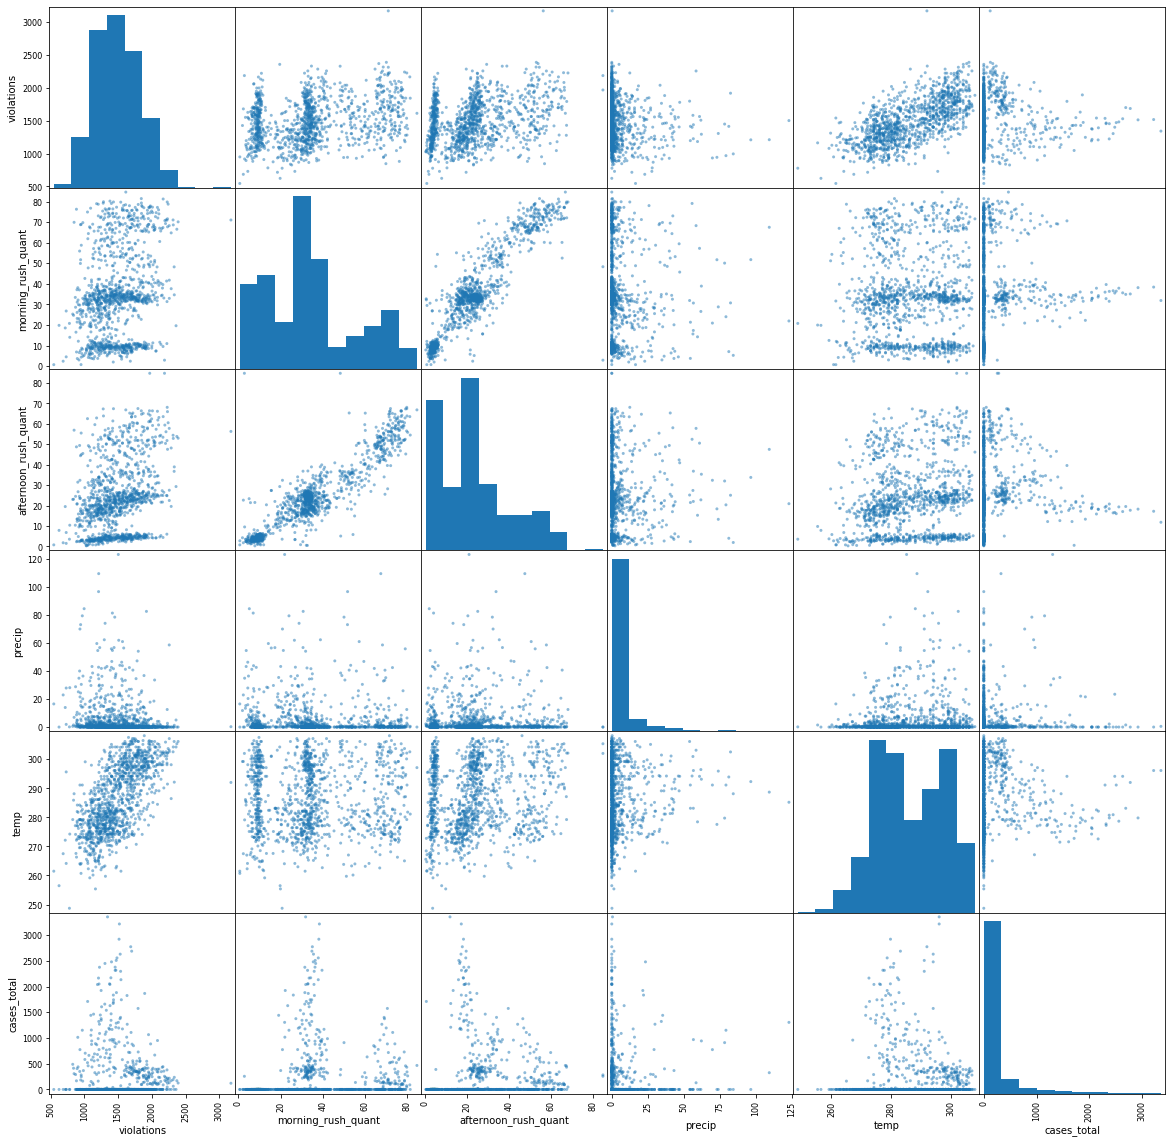

In [150]:
# scatter plot takes a few min
pd.plotting.scatter_matrix(df_cont,figsize  = [20, 20]);
plt.show()

In [151]:
df_cont.corr()  # create a correlation matrix

,violations,morning_rush_quant,afternoon_rush_quant,precip,temp,cases_total
violations,1.000000,0.268330,0.338068,-0.128026,0.663860,-0.009303
morning_rush_quant,0.268330,1.000000,0.922166,-0.020513,0.008954,0.095334
afternoon_rush_quant,0.338068,0.922166,1.000000,0.029547,0.138623,0.084164
precip,-0.128026,-0.020513,0.029547,1.000000,0.063800,0.017744
temp,0.663860,0.008954,0.138623,0.063800,1.000000,-0.024491
cases_total,-0.009303,0.095334,0.084164,0.017744,-0.024491,1.000000


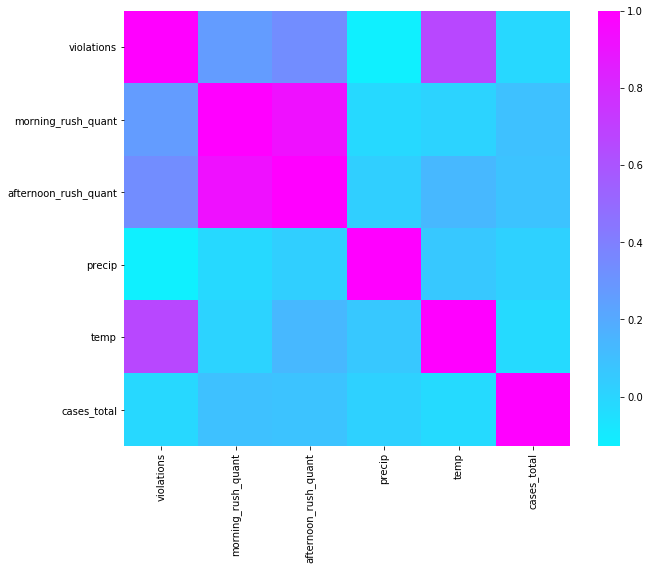

In [152]:
import seaborn as sns

plt.figure(figsize = (10,8))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [153]:
# get rid of categories that have high correlation and others.
df_continuous = df_cont.copy()
df_ohe = int_df.drop(columns=list(df_continuous.columns) + drop_me +[target])


# One hot encoding   
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [154]:
pd.options.display.max_columns = 100
df_final.head()

,violations,morning_rush_quant,afternoon_rush_quant,precip,temp,cases_total,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,1704,12.820329,10.065892,0.00,294.15,0.0,0,0,0,0,0,0
1,1623,46.627070,23.600817,0.00,292.15,0.0,0,1,0,0,0,0
2,1494,58.017443,41.146516,6.60,295.15,0.0,0,0,1,0,0,0
3,1258,58.417261,36.393470,1.12,300.15,0.0,1,0,0,0,0,0
4,1366,11.788381,5.074259,0.00,297.15,0.0,0,0,0,0,1,0


In [155]:
df_final.dropna(inplace=True)

### Test train split

In [156]:
X = df_final.drop(['violations'], axis=1)
y = df_final['violations']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [157]:
# pipeline = Pipeline([
#     ('std_scalar', StandardScaler())
# ])

# X_train = pipeline.fit_transform(X_train)
# X_test = pipeline.transform(X_test)

In [158]:
reg = LinearRegression()
reg.fit(X, y)  # my regression object

pred = reg.predict(X_test)

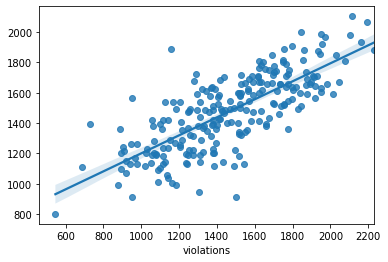

In [159]:
sns.regplot(y_test, pred)

### Plot residuals

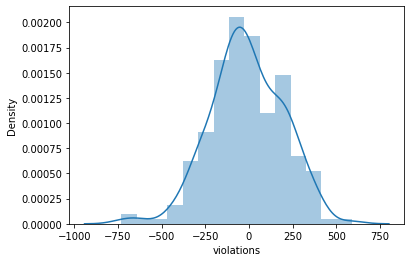

In [160]:
sns.distplot((y_test - pred), bins=15);

In [161]:
test_pred = reg.predict(X_test)
train_pred = reg.predict(X_train)

print("Linear Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Linear Regression Results:
Test set:
MAE: 165.1890399548051
MSE: 43415.43615296097
RMSE: 208.36371121901473
R2 Square 0.5733349032422426

Train set:
MAE: 154.79708627904944
MSE: 39864.56696605484
RMSE: 199.66113033350993
R2 Square 0.6365171632356337


In [162]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(reg, X_train, y_train)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,165.18904,43415.436153,208.363711,0.573335,0.625671


## Try Ridge Regression
Would like to try this since we likely have collinearity in our dataset.

In [163]:
from sklearn.linear_model import Ridge, RidgeCV

model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100])
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print("Ridge Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Ridge Regression Results:
Test set:
MAE: 166.25071173943812
MSE: 44306.56118269138
RMSE: 210.49123778127054
R2 Square 0.5645773741068993

Train set:
MAE: 154.5017085768824
MSE: 39767.14492717839
RMSE: 199.41701263226864
R2 Square 0.6374054518023784


Ridge regression showed no improvement on original model.

In [164]:
ridge = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(RidgeCV(), X_train, y_train)]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(ridge, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,165.189040,43415.436153,208.363711,0.573335,0.625671
1,Ridge Regression,166.250712,44306.561183,210.491238,0.564577,0.625800


In [166]:
#from sklearn.cross_validation import KFold



# Good time to do a baseline r_squared calculation
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(reg, X, y, scoring='r2', cv=crossvalidation))

# Do the actual regression
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

print('r_squared val:', baseline)

morning_rush_quant: -0.8108686430506855
afternoon_rush_quant: 2.6937855394826458
      precip: -4.700355733822723
        temp: 18.997149014494145
 cases_total: 0.022497125769264336
weekday_Monday: -221.75175606393438
weekday_Saturday: 104.1910900127929
weekday_Sunday: -37.99514999353409
weekday_Thursday: -128.68620074632844
weekday_Tuesday: -222.3140671747524
weekday_Wednesday: -178.86892940016548
r_squared val: 0.6163967988876127


I need more information about the intersection other than just names.
I need descriptive info, but it isn't available in violations table.  Crash data does have some stuff though

### Result

This model looked at around 50k intersection related crashes at traffic signals.  Data is aggragated for each day and 

A linear regression was chosen, so we could better make sense of the results and see the affect of each variable.

Crashes have a lot of noise in the data and are relatively infrequent events at intersections (the average Chicago intersection only has 0.4 accidents per month), so it isn't surprising to see this result. (3000 signaled intersections

Around 20% of the crashes could be explained by the model.  

Weekends (Sat/Sun) average about 4 additional accidents citywide over a typical weekday.
For every 8mm of rain/snow, we can expect an additional crash.

In the worst afternoon rush hour, you would expect 5 additional accidents.
In the best afternoon rush hour, you would expect 9 fewer accidents than average. 
(congestion is scaled from 0 to 1.  The max afternoon rush is 1, and the min is 0.13.  Mean is 0.76)

